# Import Libraries

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader,random_split,Subset
from torchvision import models
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tqdm import tqdm
import random
from collections import Counter

# Data Preparation

In [2]:
dataset_folder = "/Users/himanshu_mac/Workspace/self_projects/GradCam_on_dog_Vs_cat/kagglecatsanddogs_3367a/PetImages"

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

dataset = ImageFolder(root = dataset_folder ,
                      transform = transform )

sampled_indices = random.sample(range(len(dataset)), 2000)
sampled_dataset = Subset(dataset, sampled_indices)

labels = [label for _, label in tqdm(sampled_dataset,total = len(sampled_dataset))]
label_counts = Counter(labels)
for label, count in label_counts.items():
    print(f"Label {label}: {count} images")

train_size = int(0.8 * len(sampled_dataset))
validation_size = len(sampled_dataset) - train_size

train_dataset, val_dataset = random_split(sampled_dataset, [train_size, validation_size])

print(f"Training Dataset : {len(train_dataset)} | Validation Dataset : {len(val_dataset)}")

train_loader = DataLoader(train_dataset, shuffle= True, batch_size= 4)
val_loader = DataLoader(val_dataset, shuffle = False, batch_size= 4)

100%|██████████| 2000/2000 [00:02<00:00, 681.57it/s]

Label 1: 1003 images
Label 0: 997 images
Training Dataset : 1600 | Validation Dataset : 400


# Model Preparation

In [3]:
class ClassificationModel(nn.Module):

    def __init__(self):
        super(ClassificationModel, self).__init__()

        self.backbone = models.vit_b_16(weights=True)
        self.backbone.heads = nn.Linear(in_features=768,
                                       out_features = 2)
    
    def forward(self,x):

        return self.backbone(x)

In [4]:
def count_parameters(model):
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    non_trainable_params = total_params - trainable_params
    trainable_percentage = 100 * trainable_params / total_params

    print(f"Total parameters: {total_params}")
    print(f"Trainable parameters: {trainable_params}")
    print(f"Non-trainable parameters: {non_trainable_params}")
    print(f"Percentage of trainable parameters: {trainable_percentage:.2f}%")

model = ClassificationModel()

count_parameters(model)

/Users/himanshu_mac/Workspace/self_projects/base_env/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ViT_B_16_Weights.IMAGENET1K_V1`. You can also use `weights=ViT_B_16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Total parameters: 85800194
Trainable parameters: 85800194
Non-trainable parameters: 0
Percentage of trainable parameters: 100.00%


# Set training Parameters

In [5]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
learning_rate = 1e-5
num_epochs = 10

model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(params= model.parameters(), lr = learning_rate, weight_decay= 0.01)

# Train the model

In [6]:
def train_and_validate(model, train_loader, val_loader, criterion, optimizer, device, epochs=10):
    metrics = {
        'train': {'accuracy': [], 'precision': [], 'recall': [], 'f1_score': [], 'loss': []},
        'val': {'accuracy': [], 'precision': [], 'recall': [], 'f1_score': [], 'loss': []}
    }
    best_acc = 0.0

    for epoch in range(epochs):
        # Training
        model.train()
        train_targets, train_predictions = [], []
        train_losses = []
        for inputs, labels in tqdm(train_loader, total= len(train_loader), desc= "Training"):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            _, preds = torch.max(outputs, 1)
            train_losses.append(loss.item())
            train_targets.extend(labels.cpu().numpy())
            train_predictions.extend(preds.cpu().numpy())

        train_acc = accuracy_score(train_targets, train_predictions)
        train_prec = precision_score(train_targets, train_predictions, average='binary')
        train_rec = recall_score(train_targets, train_predictions, average='binary')
        train_f1 = f1_score(train_targets, train_predictions, average='binary')
        train_loss = sum(train_losses) / len(train_losses)

        metrics['train']['accuracy'].append(train_acc)
        metrics['train']['precision'].append(train_prec)
        metrics['train']['recall'].append(train_rec)
        metrics['train']['f1_score'].append(train_f1)
        metrics['train']['loss'].append(train_loss)

        # Validation
        model.eval()
        val_targets, val_predictions = [], []
        val_losses = []
        with torch.no_grad():
            for inputs, labels in tqdm(val_loader, total= len(val_loader), desc= "Valdiation"):
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                _, preds = torch.max(outputs, 1)
                val_losses.append(loss.item())
                val_targets.extend(labels.cpu().numpy())
                val_predictions.extend(preds.cpu().numpy())

        val_acc = accuracy_score(val_targets, val_predictions)
        val_prec = precision_score(val_targets, val_predictions, average='binary')
        val_rec = recall_score(val_targets, val_predictions, average='binary')
        val_f1 = f1_score(val_targets, val_predictions, average='binary')
        val_loss = sum(val_losses) / len(val_losses)

        metrics['val']['accuracy'].append(val_acc)
        metrics['val']['precision'].append(val_prec)
        metrics['val']['recall'].append(val_rec)
        metrics['val']['f1_score'].append(val_f1)
        metrics['val']['loss'].append(val_loss)

        print(f"Epoch {epoch+1}/{epochs} - Train Loss: {train_loss:.4f} Acc: {train_acc:.4f} Val Loss: {val_loss:.4f} Acc: {val_acc:.4f}")
    
        if val_acc > best_acc:
            best_acc = val_acc
            # best_model_wts = copy.deepcopy(model.state_dict())
            torch.save(model.state_dict(), 'best_model.pth')
            print(f'Saved new best model with accuracy: {best_acc:.4f}')
            
    return metrics

In [7]:
metrics = train_and_validate(model, train_loader, val_loader, criterion, optimizer, device, epochs = num_epochs)

Valdiation: 100%|██████████| 100/100 [00:13<00:00,  7.60it/s]


Epoch 1/10 - Train Loss: 0.0943 Acc: 0.9625 Val Loss: 0.0714 Acc: 0.9725
Saved new best model with accuracy: 0.9725


Valdiation: 100%|██████████| 100/100 [00:14<00:00,  6.72it/s]


Epoch 2/10 - Train Loss: 0.0106 Acc: 0.9975 Val Loss: 0.1015 Acc: 0.9725


Valdiation: 100%|██████████| 100/100 [00:14<00:00,  6.93it/s]


Epoch 3/10 - Train Loss: 0.0162 Acc: 0.9944 Val Loss: 0.0533 Acc: 0.9825
Saved new best model with accuracy: 0.9825


Valdiation: 100%|██████████| 100/100 [00:14<00:00,  6.81it/s]


Epoch 4/10 - Train Loss: 0.0137 Acc: 0.9944 Val Loss: 0.1119 Acc: 0.9625


Valdiation: 100%|██████████| 100/100 [00:14<00:00,  6.89it/s]


Epoch 5/10 - Train Loss: 0.0010 Acc: 1.0000 Val Loss: 0.0612 Acc: 0.9900
Saved new best model with accuracy: 0.9900


Valdiation: 100%|██████████| 100/100 [00:14<00:00,  6.71it/s]


Epoch 6/10 - Train Loss: 0.0003 Acc: 1.0000 Val Loss: 0.0633 Acc: 0.9900


Valdiation: 100%|██████████| 100/100 [00:14<00:00,  6.86it/s]


Epoch 7/10 - Train Loss: 0.0002 Acc: 1.0000 Val Loss: 0.0653 Acc: 0.9900


Valdiation: 100%|██████████| 100/100 [00:14<00:00,  6.80it/s]


Epoch 8/10 - Train Loss: 0.0001 Acc: 1.0000 Val Loss: 0.0670 Acc: 0.9900


Valdiation: 100%|██████████| 100/100 [00:14<00:00,  6.72it/s]


Epoch 9/10 - Train Loss: 0.0001 Acc: 1.0000 Val Loss: 0.0686 Acc: 0.9900


Valdiation: 100%|██████████| 100/100 [00:14<00:00,  7.05it/s]

Epoch 10/10 - Train Loss: 0.0001 Acc: 1.0000 Val Loss: 0.0701 Acc: 0.9900


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def moving_average(data, window_size):
    """ Calculate the moving average of the given list using a sliding window """
    weights = np.ones(window_size) / window_size
    return np.convolve(data, weights, mode='valid')


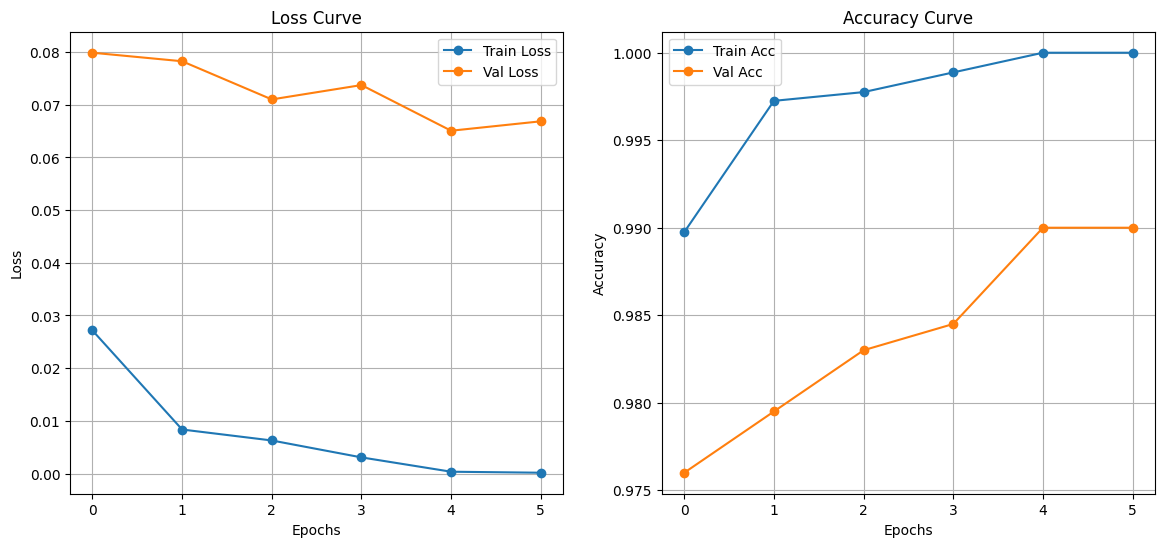

In [16]:
window_size = 5

# Calculate moving averages
smoothed_train_loss = moving_average(metrics['train']['loss'], window_size)
smoothed_val_loss = moving_average(metrics['val']['loss'], window_size)
smoothed_train_acc = moving_average(metrics['train']['accuracy'], window_size)
smoothed_val_acc = moving_average(metrics['val']['accuracy'], window_size)

plt.figure(figsize=(14, 6))

# Plotting the smoothed loss curves
plt.subplot(121)
plt.plot(smoothed_train_loss, label="Train Loss", marker = "o")
plt.plot(smoothed_val_loss, label="Val Loss", marker = "o")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss Curve")
plt.legend()
plt.grid()

# Plotting the smoothed accuracy curves
plt.subplot(122)
plt.plot(smoothed_train_acc, label="Train Acc", marker = "o")
plt.plot(smoothed_val_acc, label="Val Acc", marker = "o")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy Curve")
plt.legend()

plt.grid()
plt.show()